<a href="https://colab.research.google.com/github/khanhtran94/LearnConda/blob/master/video_17_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import cv2
import time

In [0]:
# data https://www.kaggle.com/c/cifar-10/data
zipfile.ZipFile('train_2.zip').extractall()

In [0]:
def plot_images(img):
  fig, axes = plt.subplots(2,8,figsize=(13,3))
  for i in range(8):
    axes[0,i].imshow(img[i])
    axes[0,i].axis('off')
    axes[1,i].imshow(img[i+8])
    axes[1,i].axis('off')

(50000, 32, 32, 3)


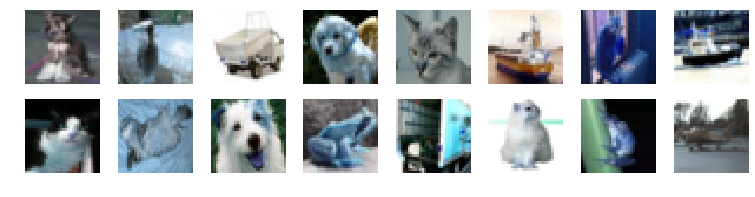

In [13]:
img_database = []
base_path = '/content/'
cartoon = base_path + 'train/'

for img in os.listdir(cartoon):
  try: 
    img_array = cv2.imread(os.path.join(cartoon, img))
    img_database.append(img_array)
  except Exception as e:
    pass
# converting to numpy array
img_database = np.array(img_database)

# print the databse
print(img_database.shape)

#total number of images selected for trainning
total_num_images = 2000

# select 2000 sample 
img_database = np.array(img_database[0:total_num_images])

#changing the image database
orig_img = img_database.astype('float32')

# image scalling
orig_img = orig_img/255

#plot the img
plot_images(orig_img)


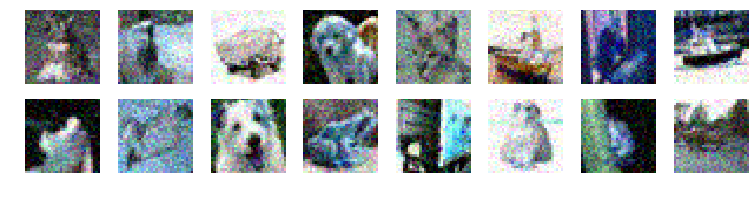

In [14]:
#create noisy image
orig_img_noisy = orig_img + 0.1*np.random.normal(loc=0.0, scale=1.0, size=orig_img.shape)

# clipping the magnitudes to lie within 0 1 
orig_img_noisy = np.clip(orig_img_noisy, 0,1)

#plotting the img
plot_images(orig_img_noisy)



In [16]:
# transpose RGB channels into 3 different independern img
print(orig_img.shape)
X_T = np.transpose(orig_img, (0,3,1,2))
print(X_T.shape)
X_T_noise = np.transpose(orig_img_noisy, (0,3,1,2))

# then flatted all pixel into one dimension

X_flat = X_T.reshape(-1,1024)
print(X_flat.shape)
X_flat_noise = X_T_noise.reshape(-1,1024)


(2000, 32, 32, 3)
(2000, 3, 32, 32)
(6000, 1024)


In [0]:
#param
learning_rate = 0.001
training_epochs = 10000
batch_size = 100
display_step = 100
examples_to_show = 8

# network param
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 128
n_input = 1024 # pokemon input img shape 40*40

In [0]:
X = tf.placeholder('float',[None, n_input])
Y = tf.placeholder('float', [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.01)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], stddev=0.01)),
    'dencoder_h1': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2], stddev=0.01)),
    'dencoder_h2': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.01)),
    'dencoder_h3': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.01)),
}

biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'encoder_b3': tf.Variable(tf.truncated_normal([n_hidden_3], stddev=0.01)),
    'dencoder_b1': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'dencoder_b2': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'dencoder_b3': tf.Variable(tf.truncated_normal([n_input], stddev=0.01)),
}

def encoder(x):
  # encoder hidden layer with sigmoid activation #1
  layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['encoder_h1']),
                                biases['encoder_b1']))
  layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,weights['encoder_h2']),
                                biases['encoder_b2']))
  layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2,weights['encoder_h3']),
                                biases['encoder_b3']))
  return layer_3

def decoder(x):
  layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['dencoder_h1']),
                                biases['dencoder_b1']))
  layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,weights['dencoder_h2']),
                                biases['dencoder_b2']))
  layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2,weights['dencoder_h3']),
                                biases['dencoder_b3']))
  return layer_3

In [0]:
# construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

#prediction
y_pred = decoder_op

#define loss and optimizer , minimize the MSE
cost = tf.reduce_mean(tf.pow(Y - y_pred,2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [33]:
start = time.time()
total_batch = int(X_flat.shape[0]/batch_size)
sess = tf.Session()
sess.run(init)

60
10000


In [38]:

for epoch in range(training_epochs):
  #loop over all batches
  start = 0; end = batch_size
  for i in range(total_batch-1):
    index = np.arange(start,end)
    np.random.shuffle(index)
    batch_xs = X_flat[index]
    batch_xsn = X_flat_noise[index]
    start = end; end = start+batch_size
    # run optimization op backprop and lost op (to get loss value)
    _,c = sess.run([optimizer, cost], feed_dict ={X: batch_xsn, Y: batch_xs})
  if(epoch%1000 == 0):
    print('Epoch: {0:05d} loss: {1:f}'.format(epoch,c))

print("optimization finished")
end = time.time()

print("time take: {0}".format(end - start))



Epoch: 00000 loss: 0.002639
Epoch: 01000 loss: 0.002567
Epoch: 02000 loss: 0.002515
Epoch: 03000 loss: 0.002463
Epoch: 04000 loss: 0.002425
Epoch: 05000 loss: 0.002351
Epoch: 06000 loss: 0.002370
Epoch: 07000 loss: 0.002369
Epoch: 08000 loss: 0.002344
Epoch: 09000 loss: 0.002432
optimization finished
time take: 1551619484.2395005


In [0]:
#random select some pokemon to visualization
# index are picked in orig_img.shape[0] , then transform to X_flat with correspond rgb row
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
print(index)
index = np.sort(index)
print(index)
RGB_index = np.concatenate((index*3,index*3+1,index*3+2))
print(RGB_index)
RGB_index = np.sort(RGB_index)
print(RGB_index)

denoised_image=sess.run(y_pred,feed_dict={X: X_flat_noise[RGB_index]})
print(denoised_image.shape)

#merge rgb rows back to rgb matrix
denoised_image = np.reshape(denoised_image, (examples_to_show,3,32,32))
print(denoised_image.shape)

denoised_image = np.transpose(denoised_image, (0,2,3,1))
print(denoised_image.shape)

#compare original images with their reconstructions
f,a = plt.subplots(3,examples_to_show, figsize=(13,5))
for i in range(examples_to_show):
  a[0][i].imshow(orig_img[index[i]])
  a[0,i].axis('off')
  a[1][i].imshow(orig_img_noisy[index[i]])
  a[1][i].axis('off')
  a[2][i].imshow(orig_img_noisy[index[i]])
  a[2][i].axis('off')
f.show()
plt.draw()



In [47]:
print(weights['encoder_h1'])

<tf.Variable 'Variable_12:0' shape=(1024, 512) dtype=float32_ref>


In [0]:
#compare inner layer reconstructions
def plot_max_active(x):
  """
  plots the images that are maximally activating the hidden units
  params x numpy array of size [input_dim, num_hidden_units]
  """
  fig,axes = plt.subplots(nrows = 10, ncols=10,figsize=(13,10))
  fig.subplots_adjust(hspace=.1,wspace=0)
  img_h = img_w = np.sqrt(x.shape[0]).astype(int)
  for i, ax in enumerate(axes.flat):
    #plot image
    ax.imshow(x[:, i].reshape((img_h,img_w)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
  plt.show()
  
plot_max_active(sess.run(weights['encoder_h1']))

In [0]:
plot_max_active(sess.run(weights['encoder_h3']))